# Using ConvNets for detecting Malaria

Malaria is one of the deadliest infectious deseases affecting more than 200 million people and killing nearly 400,000 people in 2018:

https://www.who.int/malaria/publications/world-malaria-report-2018/en/

This desease is transmitted by infective female Anopheles mosquitos, which introduce a parasite into human body by the bite. In terms of the number of human deaths this little insect represents a threat to human wealth as compared with other animal attacks:

https://www.gatesnotes.com/Health/Most-Lethal-Animal-Mosquito-Week

<img src="figures/anopheles.jpeg" style="width:550px;height:400px;">
<figcaption><center> Anopheles stephensi <br> Credits: Centers for Disease Control and Prevention's Public Health Image Library </center></caption>


Because of the impact of malaria on human health, economy (both malaria and yellow fever outbreaks hindered the construction of the Panama Canal by the French between 1891-1894) and tourism, it is important to implement more efforts to control and eradicate this desease, specially in Sub-Saharan Africa.

In this exercise we implement a convoluted neural network to detect malaria in blood cells using Keras. The data set is available in 

https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria

We implement a baseline model and then analyze individually the impact of different hyperparameters on the performance of the network. Next, we implement a grid search hyperparameter analysis following the excellent tutorial by Jason Brownlee to find the best model:

https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

Finally we assess the performance of our best model and illustrate where this model is misclassifying our samples.

Let's start!

In [1]:
import glob
#%matplotlib notebook
%matplotlib inline
#%matplotlib qt
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import numpy as np
from numpy import linspace
import math
import random
from random import shuffle

from keras import layers
from keras import models
from keras import optimizers
from keras.layers import Dropout
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

import matplotlib.pyplot as plt
plt.style.use('classic')
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
from matplotlib import pyplot
from matplotlib.image import imread
import matplotlib.colors as mcolors
import matplotlib.cm as cm

from PIL import Image               # to load images
from IPython.display import display # to display images

Using TensorFlow backend.


### A first look at the data

type  : <class 'PIL.PngImagePlugin.PngImageFile'>
format: PNG
mode  : RGB
size  : (142, 148)


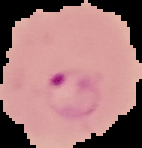

In [2]:
#Here we import the files containing the cell images: Parasitized & Uninfected
parasitized_files = glob.glob("/home/ealmaraz/dscience/sandbox/datasets/unzip/cell_images/Parasitized/*.png")
uninfected_files = glob.glob("/home/ealmaraz/dscience/sandbox/datasets/unzip/cell_images/Uninfected/*.png")

#details about the images
img = load_img(parasitized_files[0])
print('type  :',type(img))
print('format:',img.format)
print('mode  :',img.mode)

#the first number is the width; the second one is the height
#in linux we could use: identify -format "%w %h" <file> to find out which number is the width and which is the height
print('size  :', img.size)
display(img)

#### a) Parasitized cells

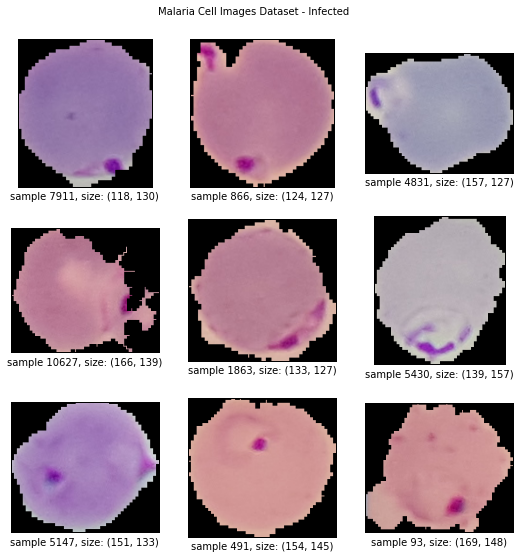

In [3]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(9,9),
                        subplot_kw={'xticks': [], 'yticks': []})

fig.suptitle('Malaria Cell Images Dataset - Infected',y=0.95);

#we select a random sample of nine files corresponding to infected cells
samples = random.sample(range(0,len(parasitized_files)),9)

for ax,sample in zip(axs.flat,samples):
    filename = parasitized_files[sample]
    image = imread(filename)
    kimage = load_img(parasitized_files[sample])
    ax.imshow(image)
    ax.set_xlabel('sample {}'.format(sample)+', size: '+ str(kimage.size))

#### b) Healthy cells

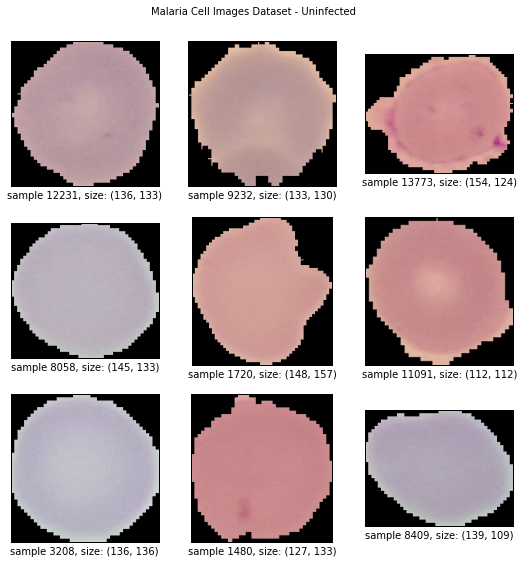

In [4]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(9,9),
                        subplot_kw={'xticks': [], 'yticks': []})

fig.suptitle('Malaria Cell Images Dataset - Uninfected',y=0.95);

#we select a random sample of nine files corresponding to healthy cells
samples = random.sample(range(0,len(uninfected_files)),9)

for ax,sample in zip(axs.flat,samples):
    filename = uninfected_files[sample]
    image = imread(filename)
    kimage = load_img(uninfected_files[sample])
    ax.imshow(image)
    ax.set_xlabel('sample {}'.format(sample)+', size: '+ str(kimage.size))

<font color='blue'>
    We see that parasitized cells are characterized by purple spots, while healthy cells lack of them (mostly). We expect that our Convoluted Neural Network (CNN) takes into account this feature to classify unseen cells into parasitized (1) and uninfected (0) cells.

### Utility functions
Here we implement the functions we use throughout our analysis

#### a) Training, validation (dev) & test sets

In [5]:
def create_datasets(ftotal,ftrain,ftest):
    '''
    This function returns the training, validation and test sets.
    Input:
        ftotal: The fraction of the whole dataset to be processed (1 means all the samples)
        ftrain: The fraction of the selected samples used for training
        ftest : The fraction of the selected samples used for testing
    The size of the validation set is given by 1-ftrain-ftest
    Output:
        train(test,dev)_files : The files corresponding to the training (test, validation) set
        train(test,dev)_array : Numpy arrays containing the pixel value of the training (test, validation) images
        train(test,dev)_labels: Numpy arrays containing the true values of the labels of the training 
                                (test, validation) images. 1: parasitized, 0: uninfected        
    '''    
    
    #we import the files containing the cell images
    parasitized_files = glob.glob("/home/ealmaraz/dscience/sandbox/datasets/unzip/cell_images/Parasitized/*.png")
    uninfected_files = glob.glob("/home/ealmaraz/dscience/sandbox/datasets/unzip/cell_images/Uninfected/*.png")
    
    #once the files are imported, we merge the two sets and create ordered pairs consisting of
    #        (name_of_the_file,true_label)
    #then, we shuffle the pairs and split each compoment. This procedure allows us to pick random samples
    #of each class
    files_list  = parasitized_files + uninfected_files 
    labels_list = [1]*len(parasitized_files)+[0]*len(uninfected_files) 
    
    
    temp = list(zip(files_list,labels_list))    
    shuffle(temp)
    files_tuples, labels_tuples = zip(*temp)
    #zip(*temp) retrieves tuples; these tuples are converted to lists by list()
    files_list = list(files_tuples)
    labels_list = list(labels_tuples)
    
    nsamples = int(ftotal*len(files_list))
    print('processing {} samples ({}% of the whole dataset)'.format(nsamples,ftotal*100))
    ntrain = int(math.floor(ftrain*nsamples))
    ntest  = int(math.floor(ftest*nsamples))
    ndev   = nsamples - ntrain - ntest
    print('training set consisting of {}% the processed samples'.format(ftrain*100))
    print('test     set consisting of {}% the processed samples'.format(ftest*100))
    print('dev      set consisting of {:.2f}% the processed samples'.format((1-ftrain-ftest)*100))
    
    #since our samples are shuffled (guaranteeing representativeness) we can construct the 
    #training, test & validation sets as following:
    train_files = files_list[0:ntrain];                       train_labels = labels_list[0:ntrain]
    test_files  = files_list[ntrain:ntrain+ntest];            test_labels  = labels_list[ntrain:ntrain+ntest]
    dev_files   = files_list[ntrain+ntest:ntrain+ntest+ndev]; dev_labels   = labels_list[ntrain+ntest:ntrain+ntest+ndev]
    
    train_list = []; train_array = np.array([])
    test_list = [];  test_array  = np.array([]) 
    dev_list = [];   dev_array   = np.array([])
    
    #here we configure the images for their analysis in Keras
    for idx in range(0,ntrain):
        im = load_img(train_files[idx],target_size=(100,100))    #we resize the images to w100 x h100
        im_array = img_to_array(im)                              #when converting to array h comes first and then w!
        train_list.append(im_array)   
    train_array = np.stack(train_list);      train_array = train_array/255.  #we normalize pixel values between 0 - 1
    train_labels = np.asarray(train_labels)

    for idx in range(0,ntest):
        im = load_img(test_files[idx],target_size=(100,100))
        im_array = img_to_array(im)   
        test_list.append(im_array)   
    test_array = np.stack(test_list);        test_array = test_array/255.
    test_labels = np.asarray(test_labels)

    for idx in range(0,ndev):
        im = load_img(dev_files[idx],target_size=(100,100))
        im_array = img_to_array(im)   
        dev_list.append(im_array)   
    dev_array = np.stack(dev_list);          dev_array = dev_array/255.
    dev_labels = np.asarray(dev_labels)
            
    return train_files, train_array, train_labels, test_files, test_array, test_labels, dev_files, dev_array, dev_labels

In [6]:
#for our analysis we use 50% of the whole data set
train_files, train_set, train_labels, test_files, test_set, test_labels, dev_files, dev_set, dev_labels = create_datasets(0.5,0.7,0.15)

processing 13779 samples (50.0% of the whole dataset)
training set consisting of 70.0% the processed samples
test     set consisting of 15.0% the processed samples
dev      set consisting of 15.00% the processed samples


#### b) Performance plots

In [7]:
def performance_plots(history,color,label):  
    '''
    This function returns a grid of (1,2) plots showing the performance of a model: 
            accuracy vs number_of_epochs     &     loss vs number_of_epochs
    Input:
        history: otput of fit() method in Keras
        color  : linecolor
        label  : label identifying the plotted model
        
    Output: None
    '''    
    
    results_dict = history.history
    epochs = range(1,len(results_dict['acc'])+1)
    
    #accuracy
    acc_values = results_dict['acc']
    val_acc_values = results_dict['val_acc']
    
    axs[0].plot(epochs, acc_values,color=color,label=label,linewidth=1.5,linestyle='-')
    axs[0].plot(epochs, val_acc_values,color=color,linewidth=1.5,linestyle='--')
    axs[0].set_xlabel('Epochs')
    minorLocatorX = AutoMinorLocator()
    axs[0].xaxis.set_minor_locator(minorLocatorX)
    axs[0].set_ylabel('accuracy')
    axs[0].set_ylim([0.5,1.02])   
    minorLocatorY = AutoMinorLocator()
    axs[0].yaxis.set_minor_locator(minorLocatorY)
    axs[0].tick_params(which='major', length=6)
    axs[0].tick_params(which='minor', length=3, color='black')       
    axs[0].legend(loc='upper left')
    
    #loss
    loss_values = results_dict['loss']
    val_loss_values = results_dict['val_loss']
       
    axs[1].plot(epochs,loss_values,color=color,label=label,linewidth=1.5,linestyle='-')
    axs[1].plot(epochs,val_loss_values,color=color,linewidth=1.5,linestyle='--')
    axs[1].set_xlabel('Epochs')
    minorLocatorX = AutoMinorLocator()
    axs[1].xaxis.set_minor_locator(minorLocatorX)   
    axs[1].set_ylabel('Loss')
    minorLocatorY = AutoMinorLocator()
    axs[1].yaxis.set_minor_locator(minorLocatorY)
    axs[1].tick_params(which='major', length=6)
    axs[1].tick_params(which='minor', length=3, color='black')    
    axs[1].legend(loc='lower left')
    
    return

#### c) CNN architecture
Here we create our CNN in Keras. Our chosen architecture is the following:

<font color='blue'>
    Input -> [Conv2D -> MaxPooling -> Dropout] -> [Conv2D -> MaxPooling -> Dropout] -> [Conv2D -> MaxPooling -> Dropout] -> [Conv2D -> MaxPooling -> Dropout] -> [FC -> Dropout] -> FC (sigmoid)

<font color='black'>
    When defining a Conv2D in Keras, we recall that by default:
    - strides = (1,1)
    - padding = 'valid'
    - data_format = 'channels_last'
    - kernel_initializer = 'glorot_uniform (Xavier's)
    - bias_initializer = 'zeros'

In [8]:
def create_model(nfilters=16,ksize=3,padd='valid',hnodes=512,dpfrac=0,optim='SGD',lrate=0.01):    
    '''
    This function creates our CNN arquitecture in Keras. The default parameters define our baseline model.
    Input: 
        nfilters: the number of filters in the first Conv2D layer. The second Conv2D layer has 2*nfilters;
                  the third has 4*nfilters, and finally the fourth layer has 8*nfilters
        ksize   : size of each filter (ksize,ksize)
        padd    : padding
        hnodes  : number of hidden nodes in the FC layer
        dpfrac  : dropout fraction in all layers
        optim   : optimizer
        lrate   : learning rate
    Our baseline model implements a 'ReLU' activation function in all intermediate layers and a 'sigmod'
    function in the last layer (since this is a binary classification problem). The number of epochs is 
    20 and the default batch size is 64. These two parameters are set when running fit()
    
    Output:
        model   : A model instantiation in Keras    
    '''
    model = models.Sequential()

    model.add(layers.Conv2D(filters=2**0*nfilters,kernel_size=(ksize,ksize),padding=padd,
                            activation='relu',input_shape=(100, 100, 3)))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dpfrac))
    
    model.add(layers.Conv2D(filters=2**1*nfilters,kernel_size=(ksize,ksize),padding=padd,
                            activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(Dropout(dpfrac))

    model.add(layers.Conv2D(filters=2**2*nfilters,kernel_size=(ksize,ksize),padding=padd,
                            activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(Dropout(dpfrac))

    model.add(layers.Conv2D(filters=2**3*nfilters,kernel_size=(ksize,ksize),padding=padd,
                            activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(Dropout(dpfrac))

    model.add(layers.Flatten())
    model.add(layers.Dense(hnodes, activation='relu'))
    model.add(Dropout(dpfrac))  
    
    model.add(layers.Dense(1, activation='sigmoid'))
    
    if optim == 'RMSprop':
        optimizer = optimizers.RMSprop(lr=lrate)
    elif optim == 'Adam':
        optimizer = optimizers.Adam(lr=lrate)
    else:
        optimizer = optimizers.SGD(lr=lrate)
        
    model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])    
    
    return model

### Assesing the effects of the hyperparameters

In this analysis, we study the effect on the performance of the CNN of:
    - The number of filters in the Conv layers
    - The kernel size
    - The padding 
    - The number of hidden nodes in the FC layer
    - The optimizer and the learning rate
    - The dropout fraction
    - The batch size

We first vary each hyperparameter individually, keeping the others constant and trying to identify which ones have the largest impact on the performance of the CNN (later on, we will perform a grid search by varying simultaneously the three most sensitive hyperparameters). To account for the variance due to the random initialization of the optimizers, we ran five realizations in each case. Here we show only the results of a single realization.

#### a) Baseline model
Training our baseline model. We use this model as a reference.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 98, 16)        448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 49, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 49, 49, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 47, 47, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 64)        18496     
__________

No handles with labels found to put in legend.
No handles with labels found to put in legend.


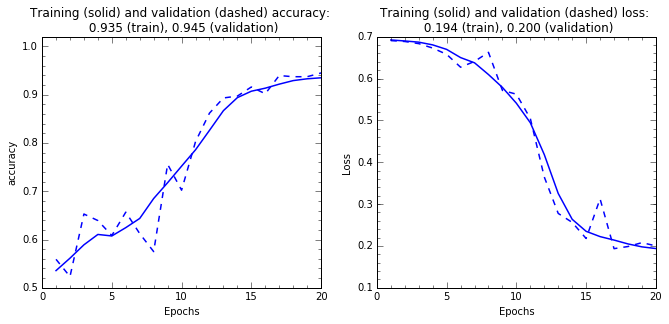

In [9]:
baseline_model = create_model()
#we display the structure of our ConvNet
baseline_model.summary()
#training: this is the most time-consuming task to be done
baseline_history = baseline_model.fit(train_set,train_labels,epochs=20,batch_size=64,
                                      validation_data=(dev_set,dev_labels),verbose=0)

#plotting
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(11,4.5))    
color = 'blue'
label = None
performance_plots(baseline_history,color,label)

axs[0].set_title('Training (solid) and validation (dashed) accuracy: \n {:.3f} (train), {:.3f} (validation)'
                 .format(baseline_history.history['acc'][-1],baseline_history.history['val_acc'][-1]));
axs[0].get_legend().remove()

axs[1].set_title('Training (solid) and validation (dashed) loss: \n {:.3f} (train), {:.3f} (validation)'
                 .format(baseline_history.history['loss'][-1],baseline_history.history['val_loss'][-1]));
axs[1].get_legend().remove()

<font color='blue'>
    We get a slight variance of $\sim 1\%$. On the other hand, the loss is very similar for the training and the validation sets. We will try to improve these results by assesing the influence of each hyperparameter on the net.

#### b) Number of filters in conv layers
As we already noted, the number of filters duplicates in each conv layer. Here we test the following configurations:
    - model_1: conv2d_1=  8, conv2d_2= 16, conv2d_3=  32, conv2d_4=  64
    - model_2: conv2d_1= 16, conv2d_2= 32, conv2d_3=  64, conv2d_4= 128  (baseline)
    - model_3: conv2d_1= 32, conv2d_2= 64, conv2d_3= 128, conv2d_4= 256

testing filter configuration = [8,16,32,64]
after 20 epochs, results are:
	 train accuracy & loss: 0.937, 0.191
	 val   accuracy & loss: 0.931, 0.203
testing filter configuration = [16,32,64,128]
this is the baseline model
after 20 epochs, results are:
	 train accuracy & loss: 0.935, 0.194
	 val   accuracy & loss: 0.945, 0.200
testing filter configuration = [32,64,128,256]
after 20 epochs, results are:
	 train accuracy & loss: 0.936, 0.188
	 val   accuracy & loss: 0.932, 0.194


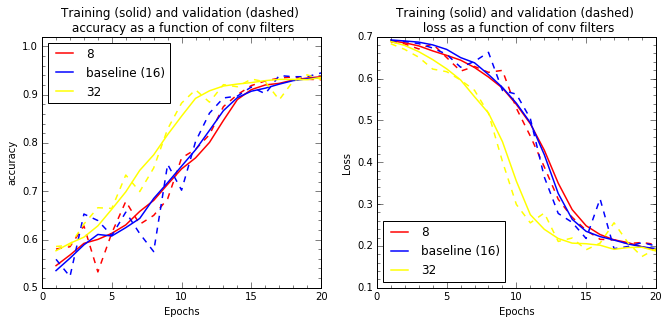

In [10]:
nfilters_grid = [8,16,32]

fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(11,4.5))    
#color map to label each model (we use the 'autumn' palette)
start  = 0;   stop = 1;   number_of_lines = len(nfilters_grid);   cm_subsection = linspace(start,stop,number_of_lines) 
colors = [cm.autumn(x) for x in cm_subsection]

for nf in nfilters_grid:
    idx = nfilters_grid.index(nf)
    print('testing filter configuration = [{},{},{},{}]'.format(nf,2*nf,2**2*nf,2**3*nf))
    
    #model_2 corresponds to our baseline model, which has already been trained and so we skip this case
    if nf == 16:
        color = 'blue'
        label = 'baseline ('+str(nf)+')'
        performance_plots(baseline_history,color,label)
        print('this is the baseline model')
        print('after {} epochs, results are:'.format(len(baseline_history.history['acc'])))    
        print('\t train accuracy & loss: {:.3f}, {:.3f}'.format(baseline_history.history['acc'][-1],baseline_history.history['loss'][-1]))
        print('\t val   accuracy & loss: {:.3f}, {:.3f}'.format(baseline_history.history['val_acc'][-1],baseline_history.history['val_loss'][-1]))
        continue
                
    model = create_model(nfilters=nf)
    model_history = model.fit(train_set,train_labels,epochs=20,batch_size=64,
                              validation_data=(dev_set,dev_labels),verbose=0)    

    print('after {} epochs, results are:'.format(len(model_history.history['acc'])))
    print('\t train accuracy & loss: {:.3f}, {:.3f}'.format(model_history.history['acc'][-1],model_history.history['loss'][-1]))
    print('\t val   accuracy & loss: {:.3f}, {:.3f}'.format(model_history.history['val_acc'][-1],model_history.history['val_loss'][-1]))
        
    label = str(nf)
    performance_plots(model_history,colors[idx],label)
    
axs[0].set_title('Training (solid) and validation (dashed) \n accuracy as a function of conv filters');
axs[1].set_title('Training (solid) and validation (dashed) \n loss as a function of conv filters');

Although model_3 learns more rapidly at the beginning, at the end the performance of the three models is practically the same. Both the accuracy and the loss function are similar to each other, so the performance of the network is insensitive to this parameter.

#### c) Kernel size
Here we study the effect of the size of the conv filters. We consider two models:
    - model_1: kernel size (3,3) (baseline)
    - model_2: kernel size (5,5)

testing kernel size = (3 X 3)
this is the baseline model
after 20 epochs, results are:
	 train accuracy & loss: 0.935, 0.194
	 val   accuracy & loss: 0.945, 0.200
testing kernel size = (5 X 5)
after 20 epochs, results are:
	 train accuracy & loss: 0.909, 0.279
	 val   accuracy & loss: 0.917, 0.239


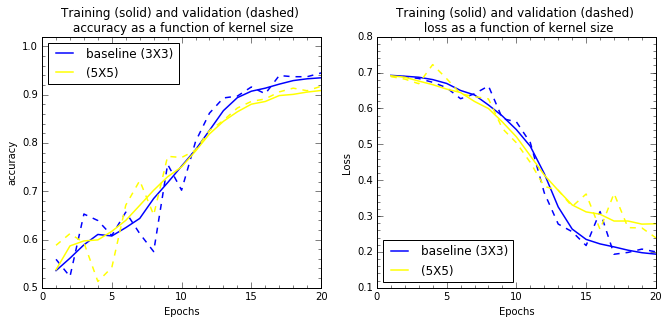

In [11]:
kernel_grid = [3,5]

fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(11,4.5))    
#color map to label each model (we use the 'autumn' palette)
start  = 0;   stop = 1;   number_of_lines = len(kernel_grid);   cm_subsection = linspace(start,stop,number_of_lines) 
colors = [cm.autumn(x) for x in cm_subsection]

for ks in kernel_grid:
    idx = kernel_grid.index(ks)
    print('testing kernel size = ({} X {})'.format(ks,ks))   

    #model_1 corresponds to our baseline model, which has already been trained and so we skip this case   
    if ks == 3:
        color = 'blue'
        label = 'baseline ('+str(ks)+'X'+str(ks)+')'
        performance_plots(baseline_history,color,label)
        print('this is the baseline model')
        print('after {} epochs, results are:'.format(len(baseline_history.history['acc'])))    
        print('\t train accuracy & loss: {:.3f}, {:.3f}'.format(baseline_history.history['acc'][-1],baseline_history.history['loss'][-1]))
        print('\t val   accuracy & loss: {:.3f}, {:.3f}'.format(baseline_history.history['val_acc'][-1],baseline_history.history['val_loss'][-1]))        
        continue
                
    model = create_model(ksize=ks)
    model_history = model.fit(train_set,train_labels,epochs=20,batch_size=64,
                              validation_data=(dev_set,dev_labels),verbose=0)    

    print('after {} epochs, results are:'.format(len(model_history.history['acc'])))
    print('\t train accuracy & loss: {:.3f}, {:.3f}'.format(model_history.history['acc'][-1],model_history.history['loss'][-1]))
    print('\t val   accuracy & loss: {:.3f}, {:.3f}'.format(model_history.history['val_acc'][-1],model_history.history['val_loss'][-1]))
        
    label = '('+str(ks)+'X'+str(ks)+')'
    performance_plots(model_history,colors[idx],label)
    
axs[0].set_title('Training (solid) and validation (dashed) \n accuracy as a function of kernel size');
axs[1].set_title('Training (solid) and validation (dashed) \n loss as a function of kernel size');

Although the accuracy and the loss curves are initially the same, we can see that the 3x3 filters perform better than the  5x5 ones.

#### d) Padding
We test two configurations:
    - model_1: 'valid', which doesn't add extra blank pixels at the borders of the images after convoluting (baseline)
    - model_2: 'same', which adds extra blank pixels so that the images have the same size after convoluting

testing "valid" padding 
this is the baseline model
after 20 epochs, results are:
	 train accuracy & loss: 0.935, 0.194
	 val   accuracy & loss: 0.945, 0.200
testing "same" padding 
after 20 epochs, results are:
	 train accuracy & loss: 0.946, 0.169
	 val   accuracy & loss: 0.946, 0.194


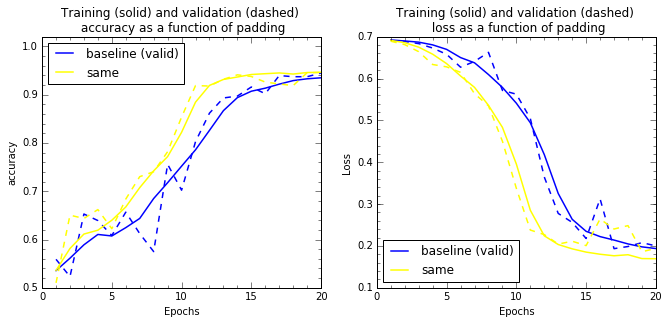

In [12]:
padding_grid = ['valid','same']

fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(11,4.5))    
#color map to label each model (we use the 'autumn' palette)
start  = 0;   stop = 1;   number_of_lines = len(padding_grid);   cm_subsection = linspace(start,stop,number_of_lines) 
colors = [cm.autumn(x) for x in cm_subsection]

for pad in padding_grid:
    idx = padding_grid.index(pad)
    print('testing "{}" padding '.format(pad))

    #model_1 corresponds to our baseline model, which has already been trained and so we skip this case       
    if pad == 'valid':
        color = 'blue'
        label = 'baseline ('+pad+')'
        performance_plots(baseline_history,color,label)
        print('this is the baseline model')
        print('after {} epochs, results are:'.format(len(baseline_history.history['acc'])))
        print('\t train accuracy & loss: {:.3f}, {:.3f}'.format(baseline_history.history['acc'][-1],baseline_history.history['loss'][-1]))
        print('\t val   accuracy & loss: {:.3f}, {:.3f}'.format(baseline_history.history['val_acc'][-1],baseline_history.history['val_loss'][-1]))
        continue
                
    model = create_model(padd=pad)
    model_history = model.fit(train_set,train_labels,epochs=20,batch_size=64,
                              validation_data=(dev_set,dev_labels),verbose=0)    

    print('after {} epochs, results are:'.format(len(model_history.history['acc'])))
    print('\t train accuracy & loss: {:.3f}, {:.3f}'.format(model_history.history['acc'][-1],model_history.history['loss'][-1]))
    print('\t val   accuracy & loss: {:.3f}, {:.3f}'.format(model_history.history['val_acc'][-1],model_history.history['val_loss'][-1]))
        
    label = pad
    performance_plots(model_history,colors[idx],label)
    
axs[0].set_title('Training (solid) and validation (dashed) \n accuracy as a function of padding');
axs[1].set_title('Training (solid) and validation (dashed) \n loss as a function of padding');

Extra padding is initially favoured, but the performance is the same than 'valid' at the end of the training.

#### e) Number of hidden nodes in the FC layer
We consider the following number of hidden nodes in the fully-connected layer of the network:

    -model_1: 256
    -model_2: 512 (baseline)
    -model_3: 1024
    -model_4: 2048

testing hidden nodes in the FC layer = 256
after 20 epochs, results are:
	 train accuracy & loss: 0.938, 0.188
	 val   accuracy & loss: 0.938, 0.185
testing hidden nodes in the FC layer = 512
this is the baseline model
after 20 epochs, results are:
	 train accuracy & loss: 0.935, 0.194
	 val   accuracy & loss: 0.945, 0.200
testing hidden nodes in the FC layer = 1024
after 20 epochs, results are:
	 train accuracy & loss: 0.918, 0.232
	 val   accuracy & loss: 0.927, 0.206
testing hidden nodes in the FC layer = 2048
after 20 epochs, results are:
	 train accuracy & loss: 0.935, 0.199
	 val   accuracy & loss: 0.943, 0.187


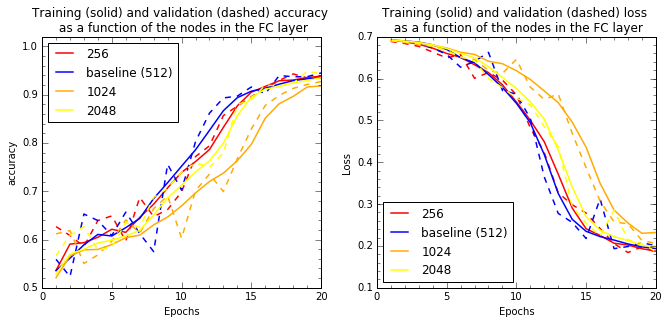

In [13]:
hnodes_grid = [256,512,1024,2048]

fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(11,4.5))    
#color map to label each model (we use the 'autumn' palette)
start  = 0;   stop = 1;   number_of_lines = len(hnodes_grid);   cm_subsection = linspace(start,stop,number_of_lines) 
colors = [cm.autumn(x) for x in cm_subsection]

for hn in hnodes_grid:
    idx = hnodes_grid.index(hn)
    print('testing hidden nodes in the FC layer = {}'.format(hn))

    #model_2 corresponds to our baseline model, which has already been trained and so we skip this case           
    if hn == 512:
        color = 'blue'
        label = 'baseline ('+str(hn)+')'
        performance_plots(baseline_history,color,label)
        print('this is the baseline model')
        print('after {} epochs, results are:'.format(len(baseline_history.history['acc'])))
        print('\t train accuracy & loss: {:.3f}, {:.3f}'.format(baseline_history.history['acc'][-1],baseline_history.history['loss'][-1]))
        print('\t val   accuracy & loss: {:.3f}, {:.3f}'.format(baseline_history.history['val_acc'][-1],baseline_history.history['val_loss'][-1]))        
        continue
                
    model = create_model(hnodes=hn)
    model_history = model.fit(train_set,train_labels,epochs=20,batch_size=64,
                              validation_data=(dev_set,dev_labels),verbose=0)    

    print('after {} epochs, results are:'.format(len(model_history.history['acc'])))
    print('\t train accuracy & loss: {:.3f}, {:.3f}'.format(model_history.history['acc'][-1],model_history.history['loss'][-1]))
    print('\t val   accuracy & loss: {:.3f}, {:.3f}'.format(model_history.history['val_acc'][-1],model_history.history['val_loss'][-1]))
        
    label = str(hn)
    performance_plots(model_history,colors[idx],label)
    
axs[0].set_title('Training (solid) and validation (dashed) accuracy \n as a function of the nodes in the FC layer');
axs[1].set_title('Training (solid) and validation (dashed) loss \n as a function of the nodes in the FC layer');

Although using 1024 nodes in the hidden layer seems to have some effect on the performance, the dependence is mild and all of the models behave similarly after 20 epochs. We conclude then that training of the network is roughly independent  of this hyperparameter. 

#### f) Optimizer and learning rate
Here we explore the joint effect of the optimizer and the learning rate. Although there are seven optimizers implemented in Keras, we only consider three of them:

    -RMSprop
    -Adam
    -Stochastic gradient descent (SGD)

In each case, we study two values of the learning rate (which differ each other by one order of magnitude):

    -lr = 0.001, 0.01

As a result, we test six combinations, where our baseline model is 'SGD' with lr=0.01

testing RMSprop optimizer with learning rate = 0.001
after 20 epochs, results are:
	 train accuracy & loss: 0.990, 0.025
	 val   accuracy & loss: 0.940, 0.383
testing RMSprop optimizer with learning rate = 0.01
after 20 epochs, results are:
	 train accuracy & loss: 0.498, 8.085
	 val   accuracy & loss: 0.501, 8.043
testing Adam optimizer with learning rate = 0.001
after 20 epochs, results are:
	 train accuracy & loss: 0.994, 0.018
	 val   accuracy & loss: 0.947, 0.333
testing Adam optimizer with learning rate = 0.01
after 20 epochs, results are:
	 train accuracy & loss: 0.499, 0.693
	 val   accuracy & loss: 0.501, 0.693
testing SGD optimizer with learning rate = 0.001
after 20 epochs, results are:
	 train accuracy & loss: 0.626, 0.689
	 val   accuracy & loss: 0.614, 0.689
testing SGD optimizer with learning rate = 0.01
this is the baseline model
after 20 epochs, results are:
	 train accuracy & loss: 0.935, 0.194
	 val   accuracy & loss: 0.945, 0.200


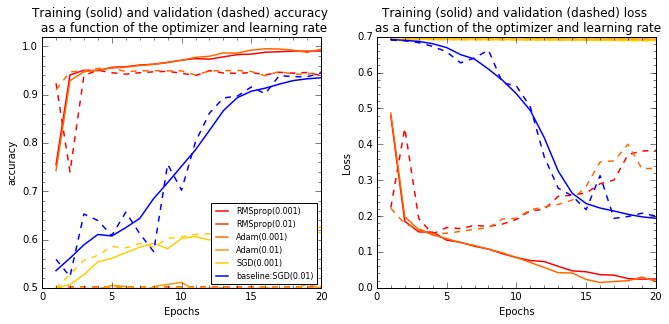

In [14]:
optimizer_grid = [(opt,lr) for opt in ['RMSprop','Adam','SGD'] for lr in [0.001,0.01]]

fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(11,4.5))    
#color map to label each model (we use the 'autumn' palette)
start  = 0;   stop = 1;   number_of_lines = len(optimizer_grid);   cm_subsection = linspace(start,stop,number_of_lines) 
colors = [cm.autumn(x) for x in cm_subsection]

for opt in optimizer_grid:
    idx = optimizer_grid.index(opt)
    print('testing {} optimizer with learning rate = {}'.format(opt[0],opt[1]))
    
    #this is our baseline model, which has already been trained and so we skip this case              
    if opt[0] == 'SGD' and opt[1] == 0.01:
        color = 'blue'
        label = 'baseline:'+opt[0]+'('+str(opt[1])+')'
        performance_plots(baseline_history,color,label)
        print('this is the baseline model')
        print('after {} epochs, results are:'.format(len(baseline_history.history['acc'])))
        print('\t train accuracy & loss: {:.3f}, {:.3f}'.format(baseline_history.history['acc'][-1],baseline_history.history['loss'][-1]))
        print('\t val   accuracy & loss: {:.3f}, {:.3f}'.format(baseline_history.history['val_acc'][-1],baseline_history.history['val_loss'][-1]))
        continue
                
    model = create_model(optim=opt[0],lrate=opt[1])
    model_history = model.fit(train_set,train_labels,epochs=20,batch_size=64,
                              validation_data=(dev_set,dev_labels),verbose=0)    

    print('after {} epochs, results are:'.format(len(model_history.history['acc'])))
    print('\t train accuracy & loss: {:.3f}, {:.3f}'.format(model_history.history['acc'][-1],model_history.history['loss'][-1]))
    print('\t val   accuracy & loss: {:.3f}, {:.3f}'.format(model_history.history['val_acc'][-1],model_history.history['val_loss'][-1]))
        
    label = opt[0]+'('+str(opt[1])+')'
    performance_plots(model_history,colors[idx],label)
    
axs[0].set_title('Training (solid) and validation (dashed) accuracy \n as a function of the optimizer and learning rate');
axs[0].legend(loc='lower right',prop={'size':8});

axs[1].set_title('Training (solid) and validation (dashed) loss \n as a function of the optimizer and learning rate');
#axs[1].legend(loc='upper right',prop={'size':8});
axs[1].set_ylim([0,0.7]);
axs[1].get_legend().remove()

We see that the performance of the network depends strongly on the choice of the optimizer and the learning rate. The models that perform better are:

    - RMSprop, lr = 0.001
    - Adam, lr = 0.001
    - SGD, lr = 0.01
    
However, although RMSprop and Adam show better accuracy and loss, we see that both optimizers overfit the training set very rapidly (in approx 4 epochs). This doesn't happen for SGD, where the training and the validation curves stay close together. Nevertheless, in this case we have a bias problem.

#### g) Dropout fraction
The overfitting problem present in the RMSprop and Adam optimizers can be reduced by regularizing the network through the deactivation (dropout) of some units of the filters and hidden nodes. Doing so, it is expected that the bias of our models increases (the trade-off dilemma). As we have just seen, overfitting is not a problem for SGD, where in the baseline model all units are present. However, dropout can be useful to allow to train the model for more epochs without overfitting. In this section, we explore this effect.

testing dropout fraction = 0.0
this is the baseline model
after 20 epochs, results are:
	 train accuracy & loss: 0.935, 0.194
	 val   accuracy & loss: 0.945, 0.200
testing dropout fraction = 0.1
after 20 epochs, results are:
	 train accuracy & loss: 0.911, 0.241
	 val   accuracy & loss: 0.921, 0.216
testing dropout fraction = 0.2
after 20 epochs, results are:
	 train accuracy & loss: 0.835, 0.400
	 val   accuracy & loss: 0.878, 0.345
testing dropout fraction = 0.3
after 20 epochs, results are:
	 train accuracy & loss: 0.783, 0.505
	 val   accuracy & loss: 0.824, 0.488
testing dropout fraction = 0.4
after 20 epochs, results are:
	 train accuracy & loss: 0.895, 0.334
	 val   accuracy & loss: 0.873, 0.327
testing dropout fraction = 0.5
after 20 epochs, results are:
	 train accuracy & loss: 0.830, 0.471
	 val   accuracy & loss: 0.771, 0.479


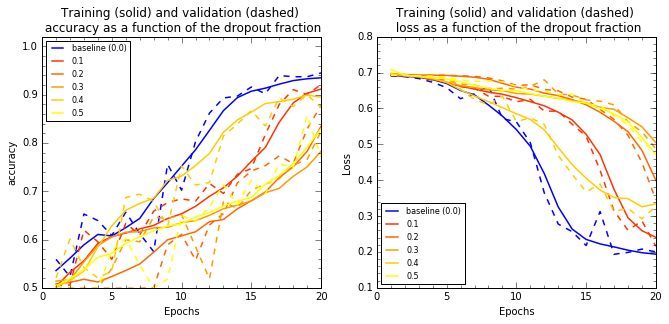

In [15]:
dropout_grid = [0.0,0.1,0.2,0.3,0.4,0.5]

fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(11,4.5))    
#color map to label each model (we use the 'autumn' palette)
start  = 0;   stop = 1;   number_of_lines = len(dropout_grid);   cm_subsection = linspace(start,stop,number_of_lines) 
colors = [cm.autumn(x) for x in cm_subsection]

for dp in dropout_grid:
    idx = dropout_grid.index(dp)
    print('testing dropout fraction = {}'.format(dp))
    
    if dp == 0.0:
        color = 'blue'
        label = 'baseline ('+str(dp)+')'
        performance_plots(baseline_history,color,label)
        print('this is the baseline model')
        print('after {} epochs, results are:'.format(len(baseline_history.history['acc'])))
        print('\t train accuracy & loss: {:.3f}, {:.3f}'.format(baseline_history.history['acc'][-1],baseline_history.history['loss'][-1]))
        print('\t val   accuracy & loss: {:.3f}, {:.3f}'.format(baseline_history.history['val_acc'][-1],baseline_history.history['val_loss'][-1]))
        continue
                
    model = create_model(dpfrac=dp)
    model_history = model.fit(train_set,train_labels,epochs=20,batch_size=64,
                              validation_data=(dev_set,dev_labels),verbose=0)    

    print('after {} epochs, results are:'.format(len(model_history.history['acc'])))
    print('\t train accuracy & loss: {:.3f}, {:.3f}'.format(model_history.history['acc'][-1],model_history.history['loss'][-1]))
    print('\t val   accuracy & loss: {:.3f}, {:.3f}'.format(model_history.history['val_acc'][-1],model_history.history['val_loss'][-1]))
        
    label = str(dp)
    performance_plots(model_history,colors[idx],label)
    
axs[0].set_title('Training (solid) and validation (dashed) \n accuracy as a function of the dropout fraction');
axs[0].legend(loc='upper left',prop={'size':8});

axs[1].set_title('Training (solid) and validation (dashed) \n loss as a function of the dropout fraction');
axs[1].legend(loc='lower left',prop={'size':8});

As we increase the dropout fraction, learning goes more slowly (it takes more epochs to the accuracy curve to increase and the loss function to decrease).

#### h) Batch size
Here we study how the performance of the network depends on the size of the batches by which the training set is divided before updating the parameters (weights and bias). We consider the following configurations:

    -model_1: 32
    -model_2: 64  (baseline)
    -model_3: 128
    -model_4: 256
    -model_5: 512

testing batch size = 32
after 20 epochs, results are:
	 train accuracy & loss: 0.945, 0.175
	 val   accuracy & loss: 0.946, 0.181
testing batch size = 64
this is the baseline model
after 20 epochs, results are:
	 train accuracy & loss: 0.935, 0.194
	 val   accuracy & loss: 0.945, 0.200
testing batch size = 128
after 20 epochs, results are:
	 train accuracy & loss: 0.726, 0.563
	 val   accuracy & loss: 0.691, 0.572
testing batch size = 256
after 20 epochs, results are:
	 train accuracy & loss: 0.656, 0.627
	 val   accuracy & loss: 0.683, 0.620
testing batch size = 512
after 20 epochs, results are:
	 train accuracy & loss: 0.612, 0.686
	 val   accuracy & loss: 0.634, 0.685


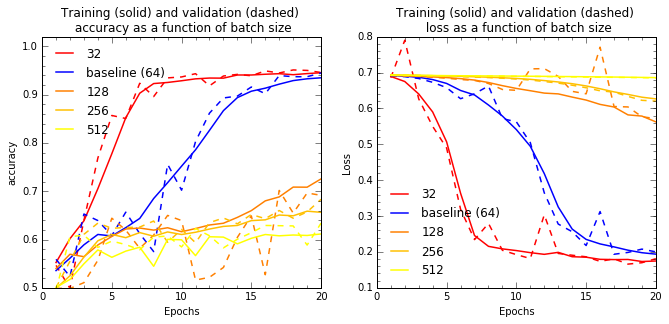

In [25]:
batch_grid = [32,64,128,256,512]

fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(11,4.5))    
#color map to label each model (we use the 'autumn' palette)
start  = 0;   stop = 1;   number_of_lines = len(batch_grid);   cm_subsection = linspace(start,stop,number_of_lines) 
colors = [cm.autumn(x) for x in cm_subsection]

for bs in batch_grid:
    idx = batch_grid.index(bs)
    print('testing batch size = {}'.format(bs))

    #model_2 corresponds to our baseline model, which has already been trained and so we skip this case               
    if bs == 64:
        color = 'blue'
        label = 'baseline ('+str(bs)+')'
        performance_plots(baseline_history,color,label)
        print('this is the baseline model')
        print('after {} epochs, results are:'.format(len(baseline_history.history['acc'])))
        print('\t train accuracy & loss: {:.3f}, {:.3f}'.format(baseline_history.history['acc'][-1],baseline_history.history['loss'][-1]))
        print('\t val   accuracy & loss: {:.3f}, {:.3f}'.format(baseline_history.history['val_acc'][-1],baseline_history.history['val_loss'][-1]))
        continue
                
    model = create_model()
    model_history = model.fit(train_set,train_labels,epochs=20,batch_size=bs,
                              validation_data=(dev_set,dev_labels),verbose=0)    

    print('after {} epochs, results are:'.format(len(model_history.history['acc'])))
    print('\t train accuracy & loss: {:.3f}, {:.3f}'.format(model_history.history['acc'][-1],model_history.history['loss'][-1]))
    print('\t val   accuracy & loss: {:.3f}, {:.3f}'.format(model_history.history['val_acc'][-1],model_history.history['val_loss'][-1]))
        
    label = str(bs)
    performance_plots(model_history,colors[idx],label)
    
axs[0].set_title('Training (solid) and validation (dashed) \n accuracy as a function of batch size');
axs[0].legend(loc='upper left',frameon=False);

axs[1].set_title('Training (solid) and validation (dashed) \n loss as a function of batch size');
axs[1].legend(loc='lower left',frameon=False);

We see that the performance of our network depends sensitively on the batch size. As the batch size is increased, the rate at which the network learns becomes slower.

### Hyperparameter grid search
From our previous results, we see that RMSprop and Adam perform better than SGD, but the models rapidly overfit the trainig set. Moreover, we have found (not shown here) that these models are not stable, meaning that the performance curves may show large variations from run to run. On the contrary, if we use the SGD optimizer there is no overfitting and the perfomance is stable over many realizations, but the model is biased. Let's see if we can ameliorate this situation. 

The performance of the network is mostly sensitive to the dropout fraction and the batch size. We also need to consider for how long we will training our model (ie, the number of epochs, which is the number of times the network surveys the training set). Therefore, for our hyperparameter grid search we consider the following configurations:

    -dropout fraction: 0, 0.1, 0.2
    -batch size      : 32, 64, 128
    -number of epochs: 20, 40, 80
    
This amounts to 3 x 3 x 3 = 27 models to fit. Here we follow the illuminating tutorial by Jason Brownlee about how to accomplish this efficiently with scikit-learn:

https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

In this respect, by default 'GridSearchCV' performs a 3-fold cross-validation splitting of the training set, which in practical terms demands a lot of computational resources. For that reason, we explore the hyperparameter space in three stages:

a) batch size = 32

In [18]:
model = KerasClassifier(build_fn=create_model,nfilters=32,verbose=0)
batch_grid = [32]
epochs_grid = [20,40,80]
dropout_grid = [0,0.1,0.2]
param_dict = dict(batch_size=batch_grid,epochs=epochs_grid,dpfrac=dropout_grid)
grid = GridSearchCV(estimator=model,param_grid=param_dict)
grid_result = grid.fit(train_set,train_labels)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.949819 using {'batch_size': 32, 'dpfrac': 0.1, 'epochs': 80}
0.643961 (0.206916) with: {'batch_size': 32, 'dpfrac': 0, 'epochs': 20}
0.941731 (0.009791) with: {'batch_size': 32, 'dpfrac': 0, 'epochs': 40}
0.647071 (0.219210) with: {'batch_size': 32, 'dpfrac': 0, 'epochs': 80}
0.932608 (0.007488) with: {'batch_size': 32, 'dpfrac': 0.1, 'epochs': 20}
0.940280 (0.012444) with: {'batch_size': 32, 'dpfrac': 0.1, 'epochs': 40}
0.949819 (0.004416) with: {'batch_size': 32, 'dpfrac': 0.1, 'epochs': 80}
0.922965 (0.005601) with: {'batch_size': 32, 'dpfrac': 0.2, 'epochs': 20}
0.933748 (0.006480) with: {'batch_size': 32, 'dpfrac': 0.2, 'epochs': 40}
0.941939 (0.013757) with: {'batch_size': 32, 'dpfrac': 0.2, 'epochs': 80}


b) batch size = 64

In [19]:
model = KerasClassifier(build_fn=create_model,nfilters=32,verbose=0)
batch_grid = [64]
epochs_grid = [20,40,80]
dropout_grid = [0,0.1,0.2]
param_dict = dict(batch_size=batch_grid,epochs=epochs_grid,dpfrac=dropout_grid)
grid = GridSearchCV(estimator=model,param_grid=param_dict)
grid_result = grid.fit(train_set,train_labels)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.937895 using {'batch_size': 64, 'dpfrac': 0.2, 'epochs': 80}
0.840954 (0.019544) with: {'batch_size': 64, 'dpfrac': 0, 'epochs': 20}
0.926594 (0.031458) with: {'batch_size': 64, 'dpfrac': 0, 'epochs': 40}
0.505858 (0.003196) with: {'batch_size': 64, 'dpfrac': 0, 'epochs': 80}
0.787455 (0.011631) with: {'batch_size': 64, 'dpfrac': 0.1, 'epochs': 20}
0.934370 (0.006288) with: {'batch_size': 64, 'dpfrac': 0.1, 'epochs': 40}
0.935614 (0.009458) with: {'batch_size': 64, 'dpfrac': 0.1, 'epochs': 80}
0.684396 (0.018667) with: {'batch_size': 64, 'dpfrac': 0.2, 'epochs': 20}
0.925868 (0.006243) with: {'batch_size': 64, 'dpfrac': 0.2, 'epochs': 40}
0.937895 (0.005681) with: {'batch_size': 64, 'dpfrac': 0.2, 'epochs': 80}


c) batch size = 128

In [20]:
model = KerasClassifier(build_fn=create_model,nfilters=32,verbose=0)
batch_grid = [128]
epochs_grid = [20,40,80]
dropout_grid = [0,0.1,0.2]
param_dict = dict(batch_size=batch_grid,epochs=epochs_grid,dpfrac=dropout_grid)
grid = GridSearchCV(estimator=model,param_grid=param_dict)
grid_result = grid.fit(train_set,train_labels)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.933333 using {'batch_size': 128, 'dpfrac': 0.1, 'epochs': 80}
0.675687 (0.021883) with: {'batch_size': 128, 'dpfrac': 0, 'epochs': 20}
0.902125 (0.009655) with: {'batch_size': 128, 'dpfrac': 0, 'epochs': 40}
0.930949 (0.006164) with: {'batch_size': 128, 'dpfrac': 0, 'epochs': 80}
0.640643 (0.016870) with: {'batch_size': 128, 'dpfrac': 0.1, 'epochs': 20}
0.805806 (0.104963) with: {'batch_size': 128, 'dpfrac': 0.1, 'epochs': 40}
0.933333 (0.004113) with: {'batch_size': 128, 'dpfrac': 0.1, 'epochs': 80}
0.598860 (0.047832) with: {'batch_size': 128, 'dpfrac': 0.2, 'epochs': 20}
0.763504 (0.157187) with: {'batch_size': 128, 'dpfrac': 0.2, 'epochs': 40}
0.920788 (0.007552) with: {'batch_size': 128, 'dpfrac': 0.2, 'epochs': 80}


<font color='blue'>
    From these results, the best-fit model is:
    
    - number of filters: 32 -> 64 -> 128 -> 256
    - kernel size      : 3 x 3
    - padding          : 'valid'
    - hidden nodes in the FC layer: 512
    - optimizer        : SGD
    - learning rate    : 0.01
    - dropout fraction : 0.1
    - batch size       : 32
    - epochs           : 80
    
The accuracy (%) is 94.98 $\pm$ 0.44, which is slightly better than the baseline model.

### Analysis of the best-fit model

#### a) Performance curves of the best-fit model
Here we plot the accuracy and the loss function curves of the best-fit model and compare them with the baseline model.

Fitting the best-fit model:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_497 (Conv2D)          (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d_497 (MaxPoolin (None, 49, 49, 32)        0         
_________________________________________________________________
dropout_621 (Dropout)        (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_498 (Conv2D)          (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_498 (MaxPoolin (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_622 (Dropout)        (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_499 (Conv2D)          (None, 21, 21, 128)

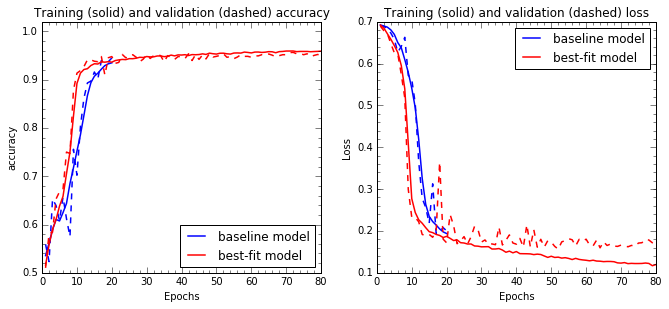

In [24]:
print('Fitting the best-fit model:')
bestfit_model = create_model(nfilters=32,dpfrac=0.1)
bestfit_model.summary()

bestfit_model_history = bestfit_model.fit(train_set,train_labels,epochs=80,batch_size=32,
                                           validation_data=(dev_set,dev_labels),verbose=1)

#plotting
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(11,4.5))    

performance_plots(baseline_history,color='blue',label='baseline model')
performance_plots(bestfit_model_history,color='red',label='best-fit model')

axs[0].set_title('Training (solid) and validation (dashed) accuracy');
axs[0].legend(loc='lower right');

axs[1].set_title('Training (solid) and validation (dashed) loss');
axs[1].set_ylim([0.1,0.7]);
axs[1].legend(loc='upper right');

#saving the fitting results
bestfit_model.save('bestfit_model.h5')

#### b) Accuracy on the test set
We now compute the accuracy of the best-fit model when classifying cells of the test set. We note that 'diff' stores the difference: $$prediction-true\_label$$for each sample in the test set. If diff == 1, our classifier is wrong; if diff==0, our classifier is right.

In [26]:
#model.evaluate(test_set,test_labels) is less expensive, but we'll need 'predictions' & 'diff' later
#numpy.rint: Round elements of the array to the nearest integer
predictions_bl = np.rint(baseline_model.predict(test_set));  predictions_bl = predictions_bl.T
diff_bl        = np.absolute(predictions_bl - test_labels);  sum_diff_bl    = np.sum(diff_bl)
accuracy_bl    = 1-sum_diff_bl/len(test_labels)

predictions_bf = np.rint(bestfit_model.predict(test_set));   predictions_bf = predictions_bf.T
diff_bf        = np.absolute(predictions_bf - test_labels);  sum_diff_bf    = np.sum(diff_bf)
accuracy_bf    = 1-sum_diff_bf/len(test_labels)

print('accuracy of the baseline model on the test set: {:.4f}'.format(accuracy_bl))
print('accuracy of the best-fit model on the test set: {:.4f}'.format(accuracy_bf))

accuracy of the baseline model on the test set: 0.9429
accuracy of the best-fit model on the test set: 0.9516


<font color='blue'>
    We see that the accuracy of the best-fit model in the test set lies within the range found in the hyperparameter grid search: 94.98 $\pm$ 0.44. This compelling result means that our network can be used to classify cells unseen by the network during the training. 

#### c) Error analysis: precision and recall
The performance of our network is not perfect. In this section we study where our network is missclasifying the samples. To that end, we compute the 'precision' and the 'recall' parameters given by: $$precision = \frac{TP}{TP+FP}, \hspace{1cm} recall = \frac{TP}{WP},$$
where $TP$ are the true positives (true parasitized cells recognized by the classifier), $FP$ are the false positives (healthy cells recognized as parasitized) and $WP$ are the total positives present in the test set (that is, irrespective of the classifier). 

Roughly speaking, the precision ratio answers the question: of the samples that our classifier recognizes as parasitized cells, how many are actually parasitized cells?

On the other hand, the recall parameter answers the following question: of all the cells that are parasitized, how many were correctly recognized by the classifier?

We expect both the precision and recall to be around 1.

In [27]:
#total parasitized cells (positive) in the test set 
wp_idx = np.where(test_labels == 1)[0]

#misclassified samples
mis_idx = np.where(diff_bf == 1)[1]

#cells classified as parasitized
pc_idx = np.where(predictions_bf == 1)[1]

#number of false positives
fp = 0.   #initialization

for idx in pc_idx:
    if idx in mis_idx:
        fp += 1.

#number of true positives
tp = len(pc_idx)-fp

precision = tp/(tp+fp)
recall    = tp/len(wp_idx)

print('precision of the best-fit model: {:.4f}'.format(precision))
print('recall of the best-fit model   : {:.4f}'.format(recall))

precision of the best-fit model: 0.9751
recall of the best-fit model   : 0.9251


#### d) Error analysis: visualization
Finally, we display some images correspondig to samples where our classifier made a mistake 

In [28]:
#these lists contain the files of the cells that where incorrectly classified
fp_files = []
fn_files = []

for idx in mis_idx:
    if test_labels[idx] == 0:
        fp_files.append(test_files[idx])
    else:
        fn_files.append(test_files[idx])

I. False positives: healthy cells that were recognized as parasitized by our classifier

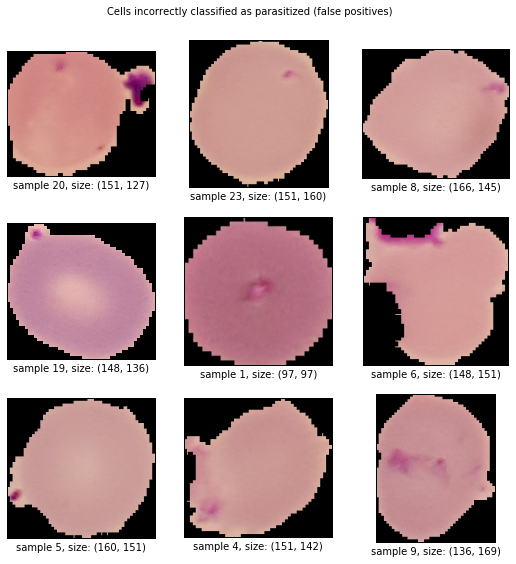

In [29]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(9,9),
                        subplot_kw={'xticks': [], 'yticks': []})

fig.suptitle('Cells incorrectly classified as parasitized (false positives)',y=0.95);

#we select a random sample of nine files corresponding to false positives
samples = random.sample(range(0,len(fp_files)),9)

for ax,sample in zip(axs.flat,samples):
    filename = fp_files[sample]
    image = imread(filename)
    kimage = load_img(filename)
    ax.imshow(image)
    ax.set_xlabel('sample {}'.format(sample)+', size: '+ str(kimage.size))

<font color='blue'>
    This is not surprising, since in all these pictures there is a purple blob, which our classifier recognizes as parasitized cells.

II. False negatives: Parasitized cells recognized as uninfected by the classifier

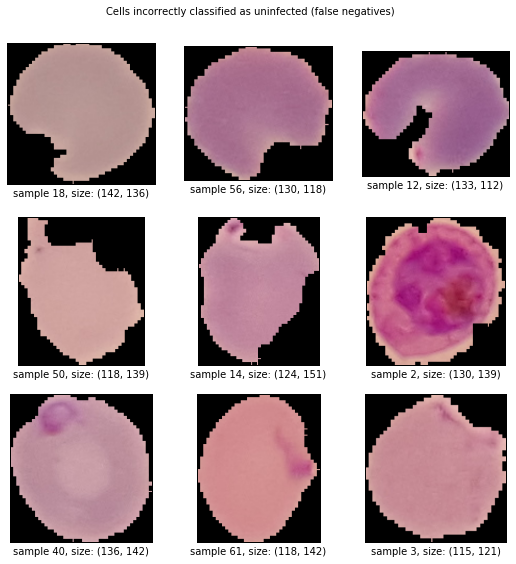

In [30]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(9,9),
                        subplot_kw={'xticks': [], 'yticks': []})

fig.suptitle('Cells incorrectly classified as uninfected (false negatives)',y=0.95);

#we select a random sample of nine files corresponding to false negatives
samples = random.sample(range(0,len(fn_files)),9)

for ax,sample in zip(axs.flat,samples):
    filename = fn_files[sample]
    image = imread(filename)
    kimage = load_img(filename)
    ax.imshow(image)
    ax.set_xlabel('sample {}'.format(sample)+', size: '+ str(kimage.size))

<font color='blue'>
    Although there are purple blobs in some pictures, we see that in some of them the cells are smooth, which our classifier recognizes as healthy. 


### Sandbox

#### a) Behavior of shuffle, zip & zip(*) in Python 3

In [31]:
a = [1,2,3]; b = [4,5,6]
c = a+b
d = ['p','p','p','u','u','u']
print('a       :',a)
print('b       :',b)
print('c=a+b   :',c)
print('d       :',d)
m = list(zip(c,d))
print('zip(c,d):', m)
shuffle(m)
print('after shuffling :', m, type(m))
final1, final2 = zip(*m)
print('first component after zip(*) :',final1, type(final1))
print('secind component after zip(*):',final2, type(final2))
final1 = list(final1)
final2 = list(final2)
print('first component converted to list :',final1, type(final1))
print('second component converted to list:',final2, type(final2))

a       : [1, 2, 3]
b       : [4, 5, 6]
c=a+b   : [1, 2, 3, 4, 5, 6]
d       : ['p', 'p', 'p', 'u', 'u', 'u']
zip(c,d): [(1, 'p'), (2, 'p'), (3, 'p'), (4, 'u'), (5, 'u'), (6, 'u')]
after shuffling : [(4, 'u'), (2, 'p'), (1, 'p'), (6, 'u'), (3, 'p'), (5, 'u')] <class 'list'>
first component after zip(*) : (4, 2, 1, 6, 3, 5) <class 'tuple'>
secind component after zip(*): ('u', 'p', 'p', 'u', 'p', 'u') <class 'tuple'>
first component converted to list : [4, 2, 1, 6, 3, 5] <class 'list'>
second component converted to list: ['u', 'p', 'p', 'u', 'p', 'u'] <class 'list'>
